In [442]:
import os
import tarfile
from six.moves import urllib
import numpy as np
import hashlib
from pandas.tools.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error

In [276]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [277]:
fetch_housing_data()

In [278]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path= os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [279]:
housing = load_housing_data()

In [7]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [280]:
# To use value_counts to count 
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [281]:
%matplotlib inline
import matplotlib.pyplot as plt

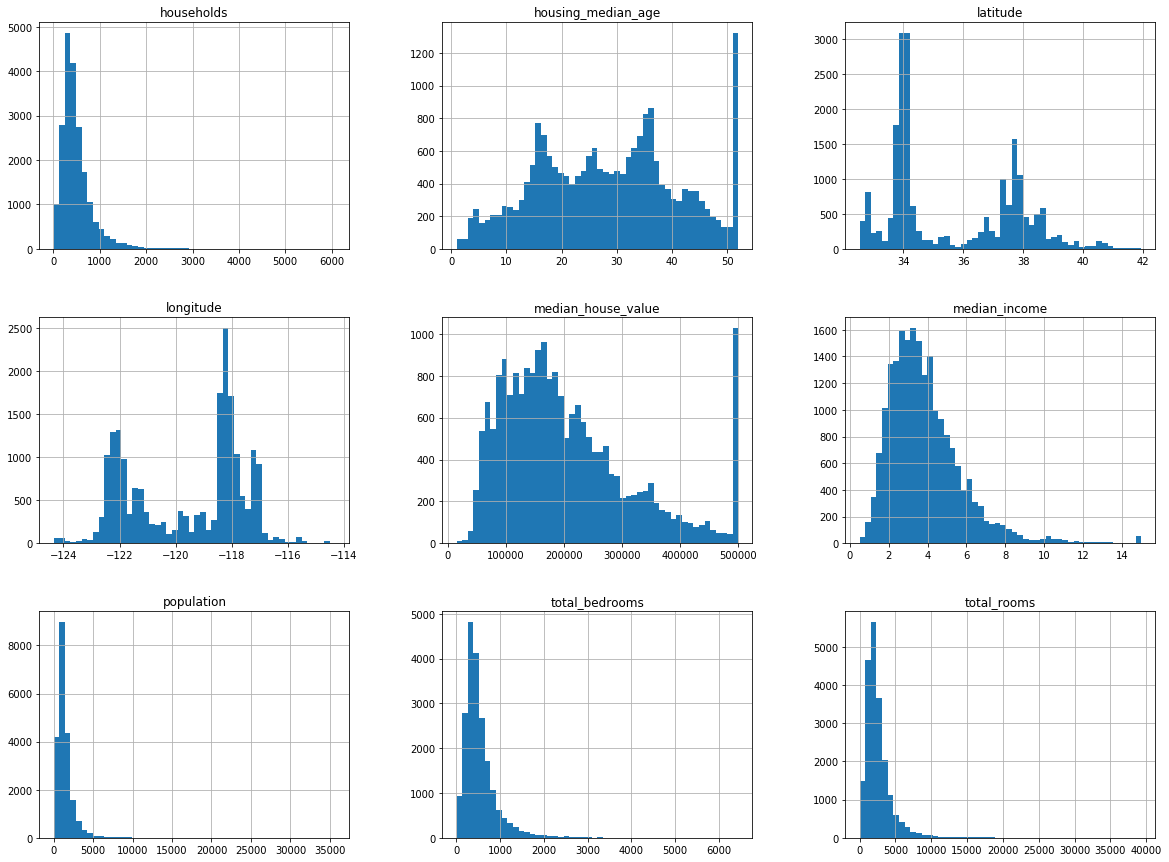

In [282]:
# drwa hist graph
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [283]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [284]:
train_set, test_set = split_train_test(housing, 0.2)

In [285]:
print(len(train_set), 'train+', len(test_set), "test")

16512 train+ 4128 test


In [286]:
# forementioned splitting method will not wind up to be same 
# training and testing set even if we set random seed(int)
# One method to use is compute hash of each instance and 
# put it in testing set if value is below 51 (20% of 256) next time,
# It will not give you what's not in previous training set to 
# testing set while you change the update data
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [287]:
housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [288]:
# ????????????????
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [289]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [290]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [291]:
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [292]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis =1, inplace=True)

In [293]:
housing = strat_train_set.copy()

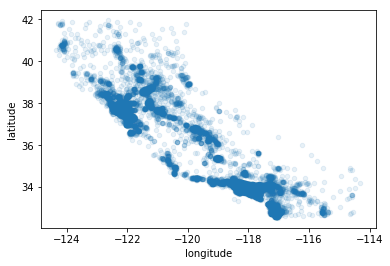

In [294]:
# visualize geographical data and see high density area clearly with alpha = 0.1
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

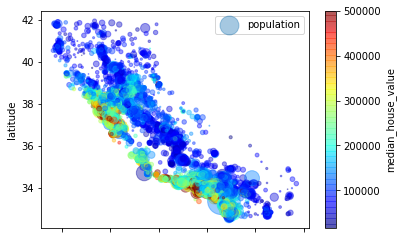

In [295]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/50,# radius of circle represents district's population
             label="population",
    c="median_house_value",# color represents the price
             cmap=plt.get_cmap('jet'), colorbar=True,
)
plt.legend()

In [296]:
# use corr and scatter matrix to see correlation
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [297]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

'\nfrom the plot, we can see\n1.strong upward trend\n2.Not too dispersed\n3.price clearly visible at 500000, 450000, 350000, 280000 which we may want to remove these data quirks\n'

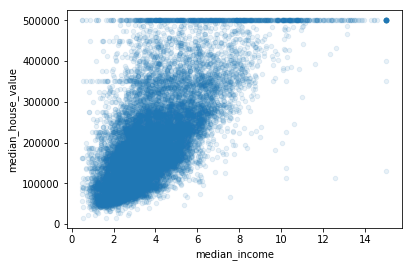

In [298]:
# attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
# scatter_matrix(housing[attributes], figsize=(12,8))
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha = 0.1)

'''
from the plot, we can see
1.strong upward trend
2.Not too dispersed
3.price clearly visible at 500000, 450000, 350000, 280000 which we may want to remove these data quirks
'''


In [149]:
'''
1.Identified data quirks to remove
2.Interesting correlations between attributes with target attr
3.Distribution with heavy tail to transform
4.Preparing to conbine various attrs e.g. the total number of rooms in a district 
is not very useful if you don’t know how many households there are
'''

'\n1.Identified data quirks to remove\n2.Interesting correlations between attributes with target attr\n3.Distribution with heavy tail to transform\n4.Preparing to conbine various attrs e.g. the total number of rooms in a district \nis not very useful if you don’t know how many households there are\n'

In [409]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [410]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [411]:
from sklearn.preprocessing import Imputer

In [412]:
imputer = Imputer(strategy="median")

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [413]:
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [414]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [415]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [416]:
X = imputer.transform(housing_num)

In [417]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

In [418]:
from sklearn.preprocessing import LabelEncoder
encoder  =LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded, housing_categories = housing_cat.factorize()

In [419]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

In [420]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [421]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [422]:
from sklearn.preprocessing import LabelBinarizer
cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat_encoded.reshape(-1,1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [423]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [424]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [425]:
cat_encoder.categories_

[array([0, 1, 2, 3, 4], dtype=object)]

In [426]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [427]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [428]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes_names].values

In [429]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [430]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [431]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# start training and evaluating the training set

In [432]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [437]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
# print(some_labels.shape)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [438]:
print("Labels: ", list(some_labels))

Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [444]:
# calculate RMSE
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

# DECISION TREE REGRESSOR

In [445]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [446]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse= mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_mse

0.0

In [450]:
def display_scores(scores):
    print("Scores: ",scores)
    print("Mean: ",scores.mean())
    print("Standard deviation: ",scores.std())

In [ ]:
# better evaluation using cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

In [452]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation:  2731.6740017983466


# RANDOM FOREST REGRESSOR

In [453]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [455]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [458]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_mse_scores = np.sqrt(-forest_scores)
display_scores(forest_mse_scores)

Scores:  [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean:  52583.72407377466
Standard deviation:  2298.353351147122


In [460]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

# SVR MODEL

In [461]:
from sklearn.svm import SVR
svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

# BEST PARAMETER COMBINATION FOR RANDOM FOREST

In [463]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    # try 3X4 combinations of hyperparameters
    {'n_estimators': [3,10,30], 'max_features':[2,4,6,8]},
    # then try 2X3 combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features':[2,3,4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [465]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [467]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65438.218425903935 {'max_features': 2, 'n_estimators': 3}
55405.72931874318 {'max_features': 2, 'n_estimators': 10}
52740.98767551001 {'max_features': 2, 'n_estimators': 30}
60486.111872712776 {'max_features': 4, 'n_estimators': 3}
52886.548445326276 {'max_features': 4, 'n_estimators': 10}
50460.471866495594 {'max_features': 4, 'n_estimators': 30}
59191.04281064942 {'max_features': 6, 'n_estimators': 3}
52601.197440717755 {'max_features': 6, 'n_estimators': 10}
50163.25081677989 {'max_features': 6, 'n_estimators': 30}
57998.54305947627 {'max_features': 8, 'n_estimators': 3}
51945.97831359665 {'max_features': 8, 'n_estimators': 10}
50198.57059488177 {'max_features': 8, 'n_estimators': 30}
61731.27575387677 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54587.29934833792 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
58842.1226294505 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52760.14483793255 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [468]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.064576,0.003022,-4.282160e+09,-1.108254e+09,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",18,-4.024547e+09,...,-4.245994e+09,-1.044292e+09,-4.175836e+09,-1.146240e+09,-4.474525e+09,-1.115090e+09,0.005998,0.000016,1.784135e+08,4.146633e+07
1,0.201940,0.009023,-3.069795e+09,-5.792287e+08,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",11,-2.902925e+09,...,-3.260866e+09,-5.705231e+08,-2.884887e+09,-5.734700e+08,-3.127973e+09,-5.751076e+08,0.009699,0.000634,1.499623e+08,1.229861e+07
2,0.598408,0.025268,-2.781612e+09,-4.323611e+08,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",7,-2.654648e+09,...,-2.926546e+09,-4.369269e+08,-2.587585e+09,-4.357680e+08,-2.848167e+09,-4.285354e+08,0.013999,0.000748,1.350486e+08,5.261707e+06
3,0.096462,0.003208,-3.658570e+09,-9.825373e+08,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",16,-3.595585e+09,...,-3.733960e+09,-9.526384e+08,-3.311471e+09,-9.410589e+08,-3.775145e+09,-1.017280e+09,0.003321,0.000401,1.955840e+08,3.629757e+07
4,0.337706,0.009224,-2.796987e+09,-5.224013e+08,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",9,-2.544955e+09,...,-2.996317e+09,-5.038059e+08,-2.661999e+09,-5.496458e+08,-2.992639e+09,-5.451617e+08,0.021240,0.000748,1.787826e+08,2.107421e+07
5,0.977318,0.023863,-2.546259e+09,-3.919786e+08,NaN,4,30,"{'max_features': 4, 'n_estimators': 30}",3,-2.377910e+09,...,-2.707677e+09,-3.818486e+08,-2.402276e+09,-3.930898e+08,-2.634790e+09,-3.948720e+08,0.017158,0.000749,1.318035e+08,8.371552e+06
6,0.134767,0.003214,-3.503580e+09,-9.268455e+08,NaN,6,3,"{'max_features': 6, 'n_estimators': 3}",15,-3.337505e+09,...,-3.633503e+09,-9.100435e+08,-3.433996e+09,-8.996120e+08,-3.723719e+09,-8.734879e+08,0.003618,0.000399,1.488842e+08,4.847036e+07
7,0.483299,0.009822,-2.766886e+09,-5.088148e+08,NaN,6,10,"{'max_features': 6, 'n_estimators': 10}",6,-2.558932e+09,...,-2.898833e+09,-4.962693e+08,-2.573573e+09,-5.109117e+08,-2.883707e+09,-4.894686e+08,0.016177,0.001607,1.642784e+08,1.699827e+07
8,1.365247,0.024265,-2.516352e+09,-3.837253e+08,NaN,6,30,"{'max_features': 6, 'n_estimators': 30}",1,-2.459423e+09,...,-2.654819e+09,-3.770791e+08,-2.356461e+09,-3.932036e+08,-2.584413e+09,-3.770692e+08,0.039818,0.000400,1.026766e+08,8.111406e+06
9,0.172460,0.003209,-3.363831e+09,-8.844369e+08,NaN,8,3,"{'max_features': 8, 'n_estimators': 3}",12,-3.444451e+09,...,-3.579847e+09,-9.367518e+08,-3.107199e+09,-8.777006e+08,-3.309590e+09,-8.319806e+08,0.004213,0.000404,1.563032e+08,3.367804e+07


# RANDOMIZED SEARCH

In [472]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {
    'n_estimators': randint(low=1,high=200),
    'max_features': randint(low=1, high=8),
}
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                               n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000225DDE44550>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000225DDE442E8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [474]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


In [475]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.44940529e-02, 7.17043878e-02, 4.30804860e-02, 1.70774129e-02,
       1.57925912e-02, 1.67768807e-02, 1.61113384e-02, 3.44945425e-01,
       4.42581239e-02, 1.15838683e-01, 8.41586325e-02, 1.18025484e-02,
       1.36074035e-01, 6.68958556e-05, 2.22063364e-03, 5.59787383e-03])

In [483]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3449454246939462, 'median_income'),
 (0.1360740345122096, 'INLAND'),
 (0.11583868278582769, 'pop_per_hhold'),
 (0.08415863247390314, 'bedrooms_per_room'),
 (0.07449405290977112, 'longitude'),
 (0.07170438782727599, 'latitude'),
 (0.04425812386299695, 'rooms_per_hhold'),
 (0.04308048603070152, 'housing_median_age'),
 (0.017077412925889355, 'total_rooms'),
 (0.016776880700513124, 'population'),
 (0.01611133835737136, 'households'),
 (0.015792591225405446, 'total_bedrooms'),
 (0.011802548363729458, '<1H OCEAN'),
 (0.005597873831601521, 'NEAR OCEAN'),
 (0.0022206336433053158, 'NEAR BAY'),
 (6.689585555218556e-05, 'ISLAND')]

In [487]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47812.3156641074